In [78]:
import os
import re
import numpy as np
import scipy
import tensorflow as tf
import tensorflow_io as tfio

import matplotlib.pyplot as plt

from IPython.display import Audio

In [74]:
# Load templates.
audio_template_foler = "./data/raw/template"
re_file = re.compile("(?P<action>.*?)_(?P<object>.*?)\.wav")

# Init memory.
all_template_audios = []
all_template_labels = []

all_filenames = os.listdir(audio_template_foler)
for filename in all_filenames:
    re_result = re_file.match(filename)
    if re_result:
        print(filename)
        
        # Get labels.
        label_action = re_result.group("action")
        label_object = re_result.group("object")
        all_template_labels.append((label_action, label_object))
        
        # Load audio file.
        audio = tfio.audio.AudioIOTensor(os.path.join(audio_template_foler, filename))
        print(audio)
        
        # Convert to tensor.
        audio_tensor = tf.squeeze(audio[:], axis=[-1])
        audio_tensor = tf.cast(audio_tensor, tf.float32) / (2**15)
        all_template_audios.append(audio_tensor)
        
print(all_template_labels)

knock_ironlocker.wav
<AudioIOTensor: shape=[17280     1], dtype=<dtype: 'int16'>, rate=32000>
knock_tabletop.wav
<AudioIOTensor: shape=[13440     1], dtype=<dtype: 'int16'>, rate=32000>
[('knock', 'ironlocker'), ('knock', 'tabletop')]


In [75]:
# Load audio files.
audio_file_folder = "./data/"
re_file = re.compile("(?P<action>.*?)_(?P<object>.*?)\.wav")

# Init memory.
all_audios = []
all_labels = []

all_filenames = os.listdir(audio_file_folder)
for filename in all_filenames:
    re_result = re_file.match(filename)
    if re_result:
        print(filename)
        
        # Get labels.
        label_action = re_result.group("action")
        label_object = re_result.group("object")
        all_labels.append((label_action, label_object))
        
        # Load audio file.
        audio = tfio.audio.AudioIOTensor(os.path.join(audio_file_folder, filename))
        print(audio)
        
        # Convert to tensor.
        audio_tensor = tf.squeeze(audio[:], axis=[-1])
        audio_tensor = tf.cast(audio_tensor, tf.float32) / (2**15)
        
        all_audios.append(audio_tensor)
        
print(all_labels)

knock_ironlocker.wav
<AudioIOTensor: shape=[290816      1], dtype=<dtype: 'int16'>, rate=32000>
knock_tabletop.wav
<AudioIOTensor: shape=[347136      1], dtype=<dtype: 'int16'>, rate=32000>
[('knock', 'ironlocker'), ('knock', 'tabletop')]


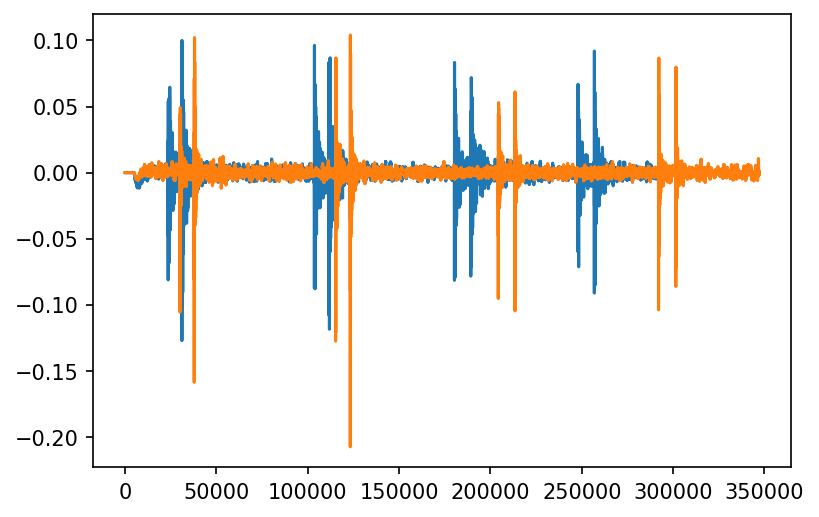

In [76]:
# Plotting.
fig, ax = plt.subplots(dpi=150)

all_audio_tensors = []
for audio, label in zip(all_audios, all_labels):    
    # Visualizing. 
    ax.plot(audio.numpy(), alpha=1)

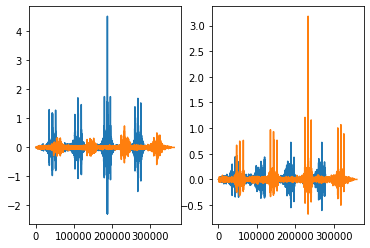

In [85]:
# Matched filtering.
# Init plot.
nrows = 1
ncols = len(all_template_labels)
fig, axes = plt.subplots(nrows=1, ncols=ncols)
axes = axes[:]

for idx, template_audio in enumerate(all_template_audios):
    ax = axes[idx]
    for audio in all_audios:
        correlation_arr = scipy.signal.correlate(template_audio, audio)
        ax.plot(correlation_arr)

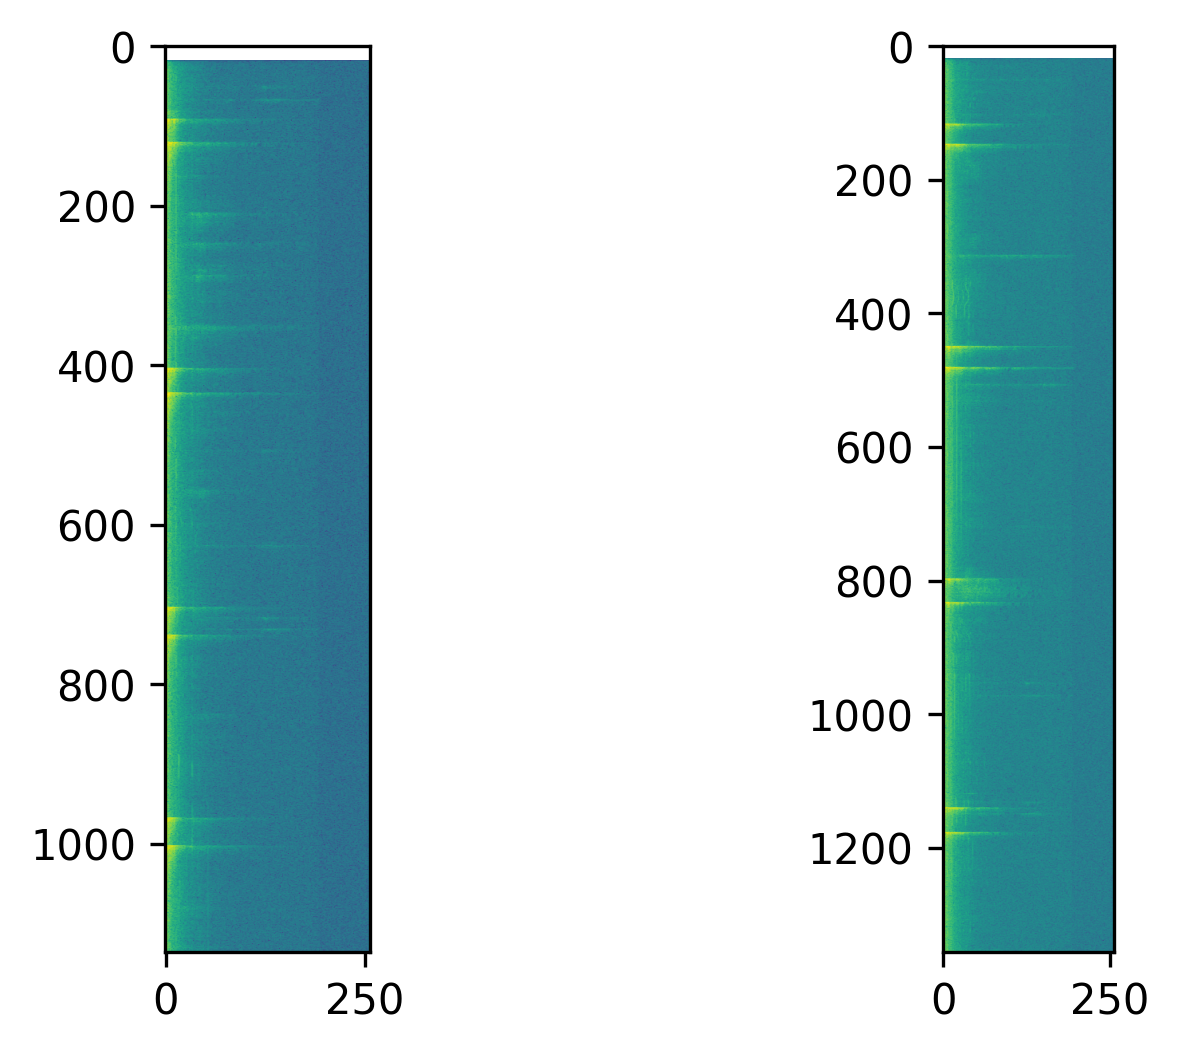

In [58]:
# Convert to spectrogram
fft_size = 512
window_size = 512
window_stride = 256

all_spectrograms = []
for audio_tensor in all_audio_tensors:
    spectrogram = tfio.audio.spectrogram(audio_tensor, nfft=fft_size, window=window_size, stride=window_stride)
    all_spectrograms.append(spectrogram)

# Plot.
ncols = min(4, len(all_labels))
nrows = int(np.ceil(len(all_labels) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, dpi=300)
axes = axes[:]

for idx, ax in enumerate(axes):
    if idx >= len(all_labels):
        break
    spectrogram = all_spectrograms[idx]
    ax.imshow(tf.math.log(spectrogram).numpy())

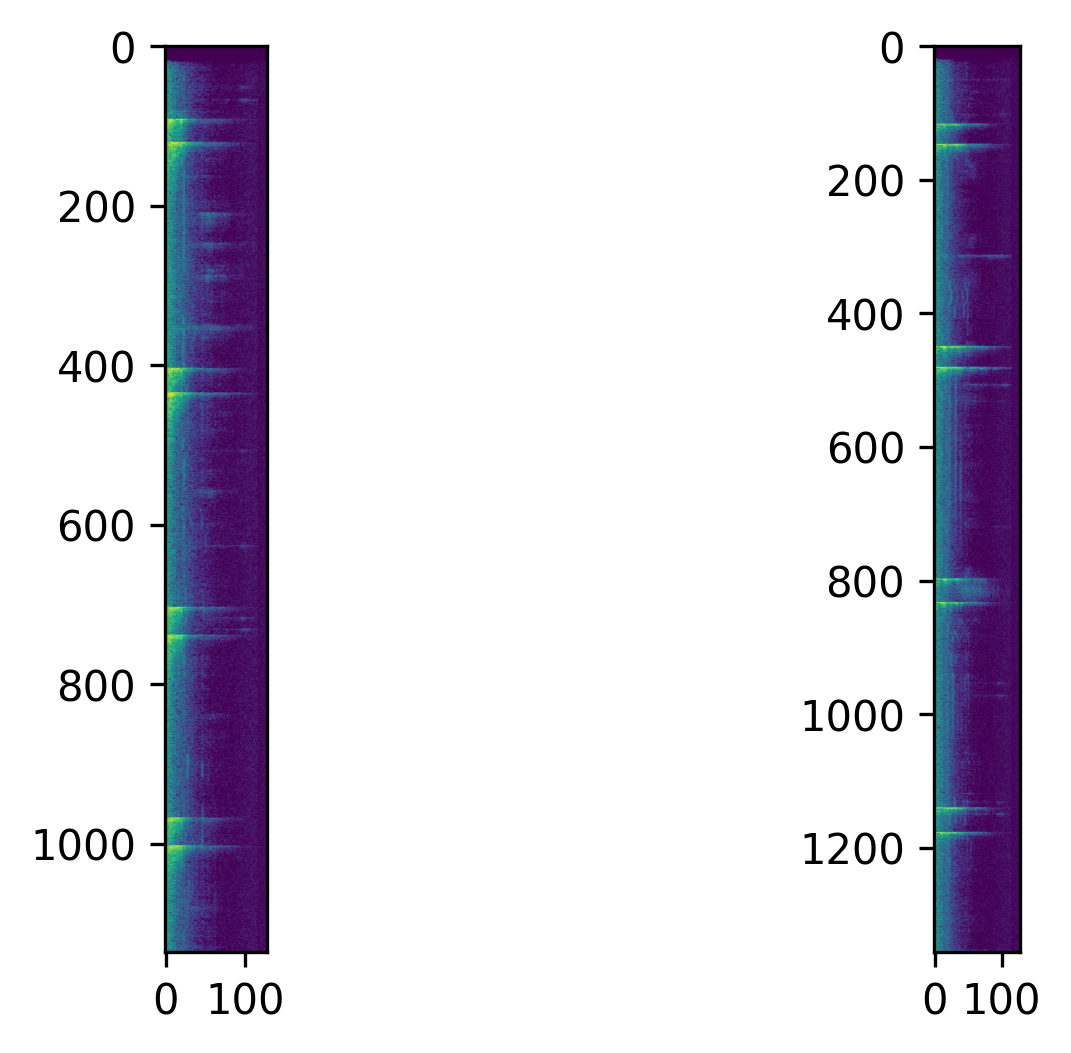

In [72]:
# Convert to db scale mel-spectrogram
fft_size = 512
window_size = 512
window_stride = 256

all_meldb_spectrograms = []
for spectrogram in all_spectrograms:
    mel_spectrogram = tfio.audio.melscale(
        spectrogram, rate=16000, mels=128, fmin=0, fmax=8000
    )
    spectrogram_meldb = tfio.audio.dbscale(
        mel_spectrogram, top_db=80)
    all_meldb_spectrograms.append(spectrogram_meldb)

# Plot.
ncols = min(4, len(all_labels))
nrows = int(np.ceil(len(all_labels) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, dpi=300)
axes = axes[:]

for idx, ax in enumerate(axes):
    if idx >= len(all_labels):
        break
    spectrogram = all_meldb_spectrograms[idx]
    ax.imshow(spectrogram.numpy())